# Модель для предсказания уровня зарплатных ожиданий сотрудников

## Импорты

In [ ]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import pickle

## Исходные данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
wdir = '/content/drive/My Drive/Courses/DataScience/DataScience/I_DIPLOMA/data'
raw_data = pd.read_excel(f'{wdir}/raw_data.xlsx')

In [5]:
raw_data.head(3)

,Unnamed: 0,entrydate,title,position,gender,city,age,salary,experience,last_job,updated,link
0,0,2020-04-08,"Резюме Менеджер по продажам мебели, дизайнер-к...",Менеджер по продажам,Женщина,Москва,31,70,8.0,ООО ИНТЕХ,2020-04-08,https://hh.ru/resume/840fd6300000a252640039ed1...
1,1,2020-04-08,Резюме Специалист по работе с клиентами,Клиентский менеджер,Мужчина,Липецк,40,90,15.0,МДК,2020-04-08,https://hh.ru/resume/66498670000716a4250039ed1...
2,2,2020-04-08,"Резюме Супервайзер торговых представителей, ст...",Супервайзер,Мужчина,Самара,34,50,7.0,Ютф-дистрибьютор,2020-04-08,https://hh.ru/resume/70e7817700035195b70039ed1...


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  3178 non-null   int64         
 1   entrydate   3178 non-null   datetime64[ns]
 2   title       3178 non-null   object        
 3   position    3178 non-null   object        
 4   gender      3178 non-null   object        
 5   city        3178 non-null   object        
 6   age         3178 non-null   int64         
 7   salary      3178 non-null   int64         
 8   experience  2522 non-null   float64       
 9   last_job    3178 non-null   object        
 10  updated     3178 non-null   datetime64[ns]
 11  link        3178 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 298.1+ KB


In [7]:
raw_data.columns

Index(['Unnamed: 0', 'entrydate', 'title', 'position', 'gender', 'city', 'age',
       'salary', 'experience', 'last_job', 'updated', 'link'],
      dtype='object')

## Предобработка данных

In [8]:
def data_prep(df_input):
  """Обрабатывает исходные данные"""
  df_output = df_input.copy()
  df_output['experience'] = df_output['experience'].fillna(
                            df_output['experience'].mean())
  df_output['experience'] = df_output['experience'].astype(np.int)
  df_output.drop([
                  'Unnamed: 0',
                  'title',
                  'entrydate',
                  'last_job',
                  'updated',
                  'link'],
                 axis=1,
                 inplace=True)
  
  return df_output

In [9]:
# Посмотрим на подготовленные данные
data = data_prep(raw_data)
data.head()

,position,gender,city,age,salary,experience
0,Менеджер по продажам,Женщина,Москва,31,70,8
1,Клиентский менеджер,Мужчина,Липецк,40,90,15
2,Супервайзер,Мужчина,Самара,34,50,7
3,Коммерческий директор,Мужчина,Краснодар,47,60,10
4,Менеджер по продажам,Мужчина,Москва,43,50,11


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3178 non-null   object
 1   gender      3178 non-null   object
 2   city        3178 non-null   object
 3   age         3178 non-null   int64 
 4   salary      3178 non-null   int64 
 5   experience  3178 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 149.1+ KB


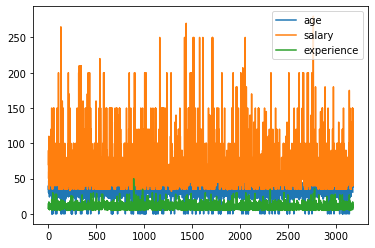

In [11]:
# Посмотрим, есть ли в данных выбросы
data.plot();

In [12]:
data[data['salary'] > 200]

,position,gender,city,age,salary,experience
130,Коммерческий директор,Мужчина,Москва,36,265,12
322,Менеджер по продажам,Мужчина,Москва,29,210,7
331,Менеджер по продажам,Мужчина,Москва,29,210,7
342,Менеджер по продажам,Мужчина,Москва,29,210,7
537,Региональный менеджер,Male,Moscow,35,220,10
1162,Менеджер по продажам,Мужчина,Москва,37,250,14
1421,Руководитель продаж,Мужчина,Москва,51,250,10
1429,Руководитель продаж,Мужчина,Москва,51,250,10
1438,Менеджер по продажам,Мужчина,Уфа,26,270,10
1511,Менеджер по продажам,Женщина,Москва,48,250,10


Пожалуй, все позиции кроме "Руководитель продаж" и "Коммерческий директор" с ожиданиями выше 200 тыс.руб - будут вносить "разлад" в наши данные. Удалим их

In [13]:
 isx = data[
      (data['salary'] > 200) & 
      (data['position'] != 'Коммерческий директор') &
      (data['position'] != 'Руководитель продаж')].index

data = data.drop(data.index[isx])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 173.3+ KB


## Feature engineering

Обогатим наши данные численностью населения в городах проживания кандидатов, источник данных: https://zema.su/blog/polnyi-spisok-vsekh-gorodov-rossii-po-chislennosti-naseleniya

In [14]:
cities = pd.read_excel(f'{wdir}/cities.xlsx')
cities = cities.drop('Н', axis=1)
cities.columns = ['city', 'population']
cities.head()

,city,population
0,Москва,11514330
1,Санкт-Петербург,4848742
2,Новосибирск,1473737
3,Екатеринбург,1350136
4,Нижний Новгород,1250615


In [15]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        1109 non-null   object
 1   population  1109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [16]:
# Добавим данные по численности к основному датасету
data_merged = data.merge(cities, how='left', left_on='city', right_on='city')
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330.0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124.0
2,Супервайзер,Мужчина,Самара,34,50,7,1164896.0
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933.0
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330.0


In [17]:
# Посмотрим % пропусков в столбце "population"
data_merged['population'].isna().sum() / len (data_merged)

0.066898075102556

In [18]:
# Пропуски есть, но не критично много
# заполним их средними значениями
data_merged['population'] = data_merged['population'].fillna(
                            data_merged['population'].mean())
# И преобразуем float к int
data_merged['population'] = data_merged['population'].astype(np.int)
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
 6   population  3169 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 198.1+ KB


In [19]:
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124
2,Супервайзер,Мужчина,Самара,34,50,7,1164896
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330


In [21]:
# Далее, преобразуем категориальные признаки в числовые
data_merged['gender_lbl'] = data_merged['gender'].apply(
                            lambda x: 1 if x == 'Мужчина' else 0
                            )
data_merged.head()

,position,gender,city,age,salary,experience,population,gender_lbl
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330,0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124,1
2,Супервайзер,Мужчина,Самара,34,50,7,1164896,1
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933,1
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330,1


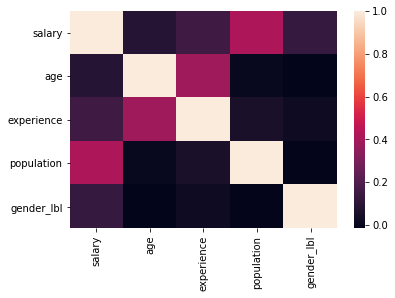

In [23]:
# Посмотрим на зависимости между признаками

from seaborn import heatmap

heatmap(
    data_merged[['salary', 
                 'age', 
                 'experience', 
                 'population', 
                 'gender_lbl']
                ].corr());

Как видно, самая сильная зависимость уровня ожиданий - от численности населения города проживания (в крупных городах ожидания явно выше)

In [24]:
# Добавим фиктивные переменные к датасету из наименований позиций
data_dummy = pd.get_dummies(data_merged.drop(['city', 'gender'], axis=1))
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Администратор,position_Водитель,position_Кам,position_Кассир,position_Кладовщик,position_Клиентский менеджер,position_Коммерческий директор,position_Курьер,position_Менеджер по закупкам,position_Менеджер по продажам,position_Менеджер по развитию,position_Мерчендайзер,position_Оператор,position_Помощник менеджера,position_Продавец-консультант,position_Региональный менеджер,position_Руководитель продаж,position_Специалист,position_Супервайзер,position_Территориальный менеджер,position_Товаровед,position_Торговый представитель,position_Управляющий магазином
0,31,70,8,11514330,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,90,15,508124,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,50,7,1164896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,47,60,10,744933,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,50,11,11514330,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


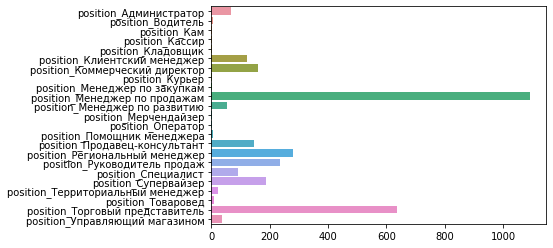

In [25]:
# Посмотрим на частые позиции
import seaborn as sns
import matplotlib.pyplot as plt

db = data_dummy.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [26]:
# Как видно, данные по позициям очень неоднородны
# Случайным образом "перемешаем" и добавим частями
# уже имеющиеся данные в датасет

from sklearn.utils import shuffle
import random

for i in range(10000):
  data_shuffle = shuffle(data_dummy).head(10)
  data_dummy = data_dummy.append(data_shuffle)

len(data_dummy)

103169

In [27]:
# Теперь выберем по 200 случайных строк по каждой позиции

balanced_data = pd.DataFrame()

for i in data_dummy.columns[5:]:
  data_filtred = data_dummy[data_dummy[i] == 1].head(200)
  balanced_data = balanced_data.append(data_filtred)

balanced_data.head()

,age,salary,experience,population,gender_lbl,position_Администратор,position_Водитель,position_Кам,position_Кассир,position_Кладовщик,position_Клиентский менеджер,position_Коммерческий директор,position_Курьер,position_Менеджер по закупкам,position_Менеджер по продажам,position_Менеджер по развитию,position_Мерчендайзер,position_Оператор,position_Помощник менеджера,position_Продавец-консультант,position_Региональный менеджер,position_Руководитель продаж,position_Специалист,position_Супервайзер,position_Территориальный менеджер,position_Товаровед,position_Торговый представитель,position_Управляющий магазином
194,31,60,8,11514330,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200,31,60,8,11514330,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
244,29,50,7,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
251,29,50,7,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
259,33,55,12,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 194 to 227
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                3506 non-null   int64
 1   salary                             3506 non-null   int64
 2   experience                         3506 non-null   int64
 3   population                         3506 non-null   int64
 4   gender_lbl                         3506 non-null   int64
 5   position_Администратор             3506 non-null   uint8
 6   position_Водитель                  3506 non-null   uint8
 7   position_Кам                       3506 non-null   uint8
 8   position_Кассир                    3506 non-null   uint8
 9   position_Кладовщик                 3506 non-null   uint8
 10  position_Клиентский менеджер       3506 non-null   uint8
 11  position_Коммерческий директор     3506 non-null   uint8
 12  position_Курьер    

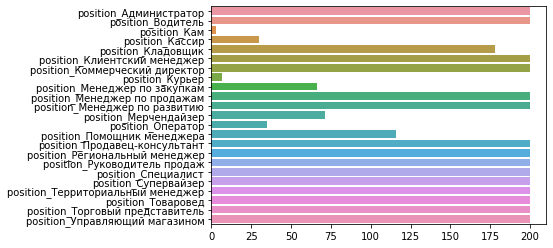

In [29]:
# Снова посмотрим на позиции
import seaborn as sns
import matplotlib.pyplot as plt

db = balanced_data.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

Совсем другое дело...

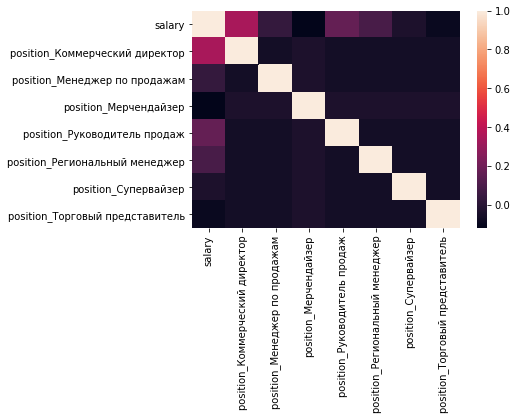

In [30]:
import seaborn as sns
from seaborn import heatmap

heatmap(balanced_data[['salary',
                   'position_Коммерческий директор',
                   'position_Менеджер по продажам',
                   'position_Мерчендайзер',
                   'position_Руководитель продаж',
                    'position_Региональный менеджер',
                   'position_Супервайзер',
                   'position_Торговый представитель'
                    ]].corr());

Также на примере мы видим явную зависимость между статусными позициями, такими как "Коммерческий директор" и "Руководитель продаж" и уровнем их ожиданий по доходу

## Подготовка и построение модели

### Разбиение выборки

In [31]:
from sklearn.model_selection import train_test_split

rs = 42


def data_split(data):
  """Hold-out разбиение на две выборки"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True,
      random_state=rs
      )
  
  return X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = data_split(balanced_data)

In [33]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Тип выборки", "Размерность"]
x.add_row(["Исходная выборка", balanced_data.shape])
x.add_row(["X_train", X_train.shape])
x.add_row(["X_test", X_test.shape])
x.add_row(["y_train", y_train.shape])
x.add_row(["y_test", y_test.shape])
print(x)

+------------------+-------------+
|   Тип выборки    | Размерность |
+------------------+-------------+
| Исходная выборка |  (3506, 28) |
|     X_train      |  (2804, 27) |
|      X_test      |  (702, 27)  |
|     y_train      |   (2804,)   |
|      y_test      |    (702,)   |
+------------------+-------------+


Наша задача предсказания ожиданий кандидата по уровню оплаты труда сводится к классической задаче регрессии (с учителем). Рассмотрим несколько моделей.

Начнем с самого простого

### Обучение sklearn.LinearRegression

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae


def train_linreg(data):
  """Обучает модель регрессии"""

  X_train, X_test, y_train, y_test = data_split(data)
 
  # Описание модели
  model = LinearRegression()
  
  # Обучение модели
  model.fit(
      X_train, y_train
      )
  
  # Предсказание на основании обученной модели
  y_pred = model.predict(X_test)
  
  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('mae:', error)

In [35]:
sklr = train_linreg(balanced_data)

mae: 15.356253133910084


Метрику `mae` выберем в связи с ее высокой интуитивностью, ведь все понимают, что ошибка модели в 15 тысяч рублей при средней ожидаемой зарплате в 65 тыс.рублей - это достаточно много (22% - показатель MAPE). Попробуем усложнить решение

### Обучение модели RandomForest с бэггингом

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error as mae


def train_forest(data, nest, mss, msl):
  """Обучает модель регрессии RandomForest"""

  X_train, X_test, y_train, y_test = data_split(data)

  # Описание модели
  model = RandomForestRegressor(
      n_estimators=nest, # количество деревьев (макс=100)
      criterion='mae',
      min_samples_split=mss, # минимальное разбиение выборок
      min_samples_leaf=msl, # минимальное количество листов в узле
      n_jobs=5, # количество параллельных джоб
      bootstrap=True # моделирует наличие бОльшено V-ма данных
  )
  
  # Используем бэггинг для усиления алгоритма
  model = BaggingRegressor(model)

  # Обучение модели
  model.fit(
      X_train, y_train
  )

  # Предсказание на основании обученной модели
  y_pred = model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  return error, nest, mss, msl

#### Оптимизация гиперпараметров

In [41]:
from itertools import product

# Гиперпараметры
nest = range(50, 100, 20)
mss = range(2, 10, 2)
msl = range(2, 10, 2)

parameters = product(nest, mss, msl)
parameters_list = list(parameters)

# Количество параметров для перебора
len(parameters_list)

48

In [42]:
import warnings

%timeit
results = []
best_mae = float("inf")

for param in parameters_list:
  model=train_forest(balanced_data, param[0], param[1], param[2])
  res_mae = model[0]
  if res_mae < best_mae:
    best_model = model
    best_mae = res_mae
    best_param = param
    results.append([param, model[0]])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'res_mae']
print(result_table.sort_values(by = 'res_mae', ascending=True).head())

   parameters   res_mae
1  (50, 4, 2)  7.970871
0  (50, 2, 2)  8.094365


Минимальное значение MAE достигается при:
- n_estimators=50
- min_samples_split=4
- min_samples_leaf=2

Уже неплохо. MAE в %% (MAPE) - 12%, т.е. точность модели 88%

## Сериализация модели

In [83]:
def serial_forest(data):
  """Сохраняет модель регрессии RandomForest"""

  X_train, X_test, y_train, y_test = data_split(data)

  # Описание модели
  model = RandomForestRegressor(
      n_estimators=50, # Подставляем оптимальные значения)
      criterion='mae',
      min_samples_split=4,
      min_samples_leaf=2,
      n_jobs=5,
      bootstrap=True
  )
  
  # Используем бэггинг для усиления алгоритма
  model = BaggingRegressor(model)

  # Обучение модели
  model.fit(
      X_train, y_train
  )

  # Сериализация модели
  with open('jsp_model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [ ]:
serial_forest(balanced_data)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!ls

catboost_info  drive  jsp_model.pkl  sample_data
